In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing.imputation import Imputer
from sklearn import datasets
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm

baseball_file_path = '/Users/HuanLiang/Desktop/Winning and Baseball/MLB Data v6.csv'
baseball_data = pd.read_csv(baseball_file_path)

/Users/HuanLiang/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Introduction

This is the extension of the "winning and revenue in the MLB" project that I completed in Chicago Booth's Sports Analytics class with Professors Huizinga and Murphy. Unlike my analysis in R, I'd like to try to use economic and performance variables to predict whether a major league baseball team will make the playoffs in the following season. The data is the same data that our team collected for the original project. After reading the analysis, I'd love some feedback on what I did, if you would do anything differently, or anything of that sort.

## Data Preparation

First, we take a look at the data and see which variables make the most sense in predicting revenue. I believe it is important to get an intuitive sense of which factors play the largest role in predicting playoff appearance before performing any visualizations or calculations. What variables make the most sense in predicting the success of a baseball team in the previous year?

In [2]:
for i in baseball_data.columns:
    print(i)

Year
Team
Year.Team.Variable
stadium
stadium_built
stadium_age
capacity
yearly_capacity
stadium_fill_perc
Total_Attendance
FCI
CPI
Real_FCI_2016
revenue
real_revenue_2016
team_value
post_season_appearance
postseason_nextyear
WS_winner
prev_3_wins
population
per_capita_income
relative_strength_index
Modified_RSI
strength_of_schedule
Opp_Run_Diff
ESPN_SoS
Opp_Win_P
Team_WAR
NumGames
W
L
T
RS_total
RS_WL
RS_WLH
RS_WLV
RS_T
RS_TH
RS_TV
RA_total
RA_WL
RA_WLH
RA_WLV
RA_T
RA_TH
RA_TV
stad_age_1
stad_age_2
stad_age_3
stad_age_4
stad_age_5
stad_age_6
stad_age_7
lrg_market
mid_market
sm_market
before_2001
Wsqr
Wcube
LY_RSI
LY2_RSI
LY3_RSI
LY_wins
LY2_wins
LY3_wins
LY_playoffs
LY2_playoffs
LY3_playoffs
LY_WS
LY2_WS
LY3_WS
Wins_below60
Wins_60to70
Wins_70to80
Wins_80to90
Wins_90to100
LYWins_below60
LYWins_60to70
LYWins_70to80
LYWins_80to90
LYWins_90to100
LYW_below_95
LY4_RSI
LY5_RSI
LY4_playoffs
LY5_playoffs
LY_Mod.RSI
LY2_Mod.RSI
LY3_Mod.RSI
LY4_Mod.RSI
LY5_Mod.RSI
SoSLY
SoSLY2
SoSLY3
SoSLY4
SoSL

I used a for loop to display all the columns headings. From the printed headings, I picked the headings that I thought made the most sense. For example, wins determine success but revenue and attendance might also affect the overall "success" of a team. High attendance means that the team is worth watching. High revenue means that the team is able to purchase good players. Note that the dependent variable is the postseason_nextyear variable.

In [3]:
baseball_vars = ['real_revenue_2016', 'W', 'Total_Attendance', 'per_capita_income', 'RS_total', 
                     'stadium_age', 'post_season_appearance', 'postseason_nextyear',
                     'RA_total']
baseball_pred_data = baseball_data[baseball_vars]
y = baseball_pred_data.postseason_nextyear
predictors = ['real_revenue_2016', 'W', 'Total_Attendance', 'per_capita_income', 'RS_total', 
                     'stadium_age', 'post_season_appearance',
                     'RA_total']
X = baseball_data[predictors]

In [4]:
baseball_pred_data.describe()

,real_revenue_2016,W,Total_Attendance,per_capita_income,RS_total,stadium_age,post_season_appearance,postseason_nextyear,RA_total
count,6.980000e+02,698.000000,6.980000e+02,698.000000,698.00000,698.000000,698.000000,698.000000,698.000000
mean,1.209168e+08,79.746418,2.398896e+06,40820.861676,740.82235,27.229226,0.256447,0.262178,740.085960
std,5.707538e+07,12.264196,7.074398e+05,11233.024234,92.86965,25.461968,0.436985,0.440134,97.410952
min,3.005903e+07,43.000000,8.131270e+05,21903.000000,466.00000,1.000000,0.000000,0.000000,448.000000
25%,7.879968e+07,71.000000,1.821472e+06,32214.000000,679.00000,9.000000,0.000000,0.000000,674.000000
50%,1.079515e+08,80.000000,2.352582e+06,40117.850000,739.50000,19.000000,0.000000,0.000000,739.000000
75%,1.515427e+08,89.000000,2.949038e+06,48017.250000,801.00000,36.000000,1.000000,1.000000,807.500000
max,4.274713e+08,116.000000,4.446678e+06,84675.000000,1009.00000,105.000000,1.000000,1.000000,1103.000000


Now we have a snapshot of our explanatory variables, let's explore our data even further and determine which variables it makes sense to include in our model.

## Dependent Variable exploration

Now, let's take a closer look at our dependent variable: postseason_nextyear. Of course, a one means that the team made the postseason the following year, and a zero means the opposite.

In [5]:
y.value_counts()

0    515
1    183
Name: postseason_nextyear, dtype: int64

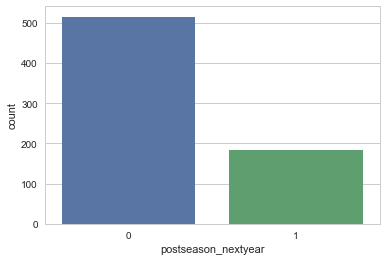

In [6]:
sns.countplot(y)


As expected, there are more than twice the number of teams that failed to make the playoffs as opposed to number of teams that did make the playoffs in the following year. Of course, out of about thirty teams in the MLB each season, only eight teams make the playoffs. Now, what is so special about these teams? Let's take a look by grouping the data based on our dependent variable.

In [7]:
baseball_pred_data.groupby('postseason_nextyear').mean()

,real_revenue_2016,W,Total_Attendance,per_capita_income,RS_total,stadium_age,post_season_appearance,RA_total
postseason_nextyear,,,,,,,,
0,1.123147e+08,77.695146,2.292807e+06,40482.961223,731.058252,24.809709,0.182524,751.007767
1,1.451247e+08,85.519126,2.697451e+06,41771.783716,768.300546,34.038251,0.464481,709.349727


In [8]:
baseball_pred_data.groupby('postseason_nextyear').median()

,real_revenue_2016,W,Total_Attendance,per_capita_income,RS_total,stadium_age,post_season_appearance,RA_total
postseason_nextyear,,,,,,,,
0,102145267.3,78,2249201,39870.0,730,17,0,751
1,138675492.9,87,2776531,42006.0,772,25,0,705


Wow! The mean and the median show similar insights. For example, data where postseason_nextyear = 1 had higher revenue, more wins, more attendance, higher income, scored more runs and had fewer runs scored against them. The stadium age seems a big odd, as teams with older stadiums seem to make the playoffs in the following season more often. Perhaps older stadiums means more established teams? There's a lot of things to take into consideration here. Now, let's use seaborn to visualize the distributions of the explanatory variables given postseason_nextyear = 0 and postseason_nextyear = 1.

## Data Visualization

Let's take a look at the distributions, starting with revenue.

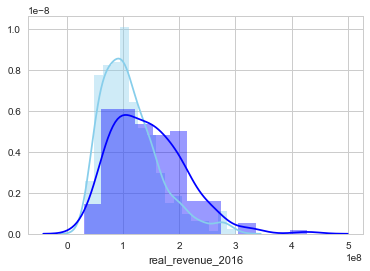

In [9]:
sns.distplot(baseball_pred_data.real_revenue_2016.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.real_revenue_2016.loc[y == 1], color="blue")

Looking at revenue alone, playoff teams are shifted to the right in the revenue axis. There is also a more even spread in the dark blue distribution. Non-playoff teams have a spike in revenue and is less uniform. Let's take a look at the distribution of wins.

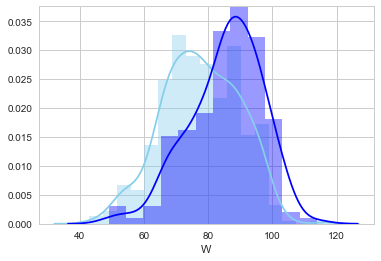

In [10]:
sns.distplot(baseball_pred_data.W.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.W.loc[y == 1], color="blue")

This shift is much more apparent, and rightfully so. Success of a team often transfers to the following year. What about total attendance?

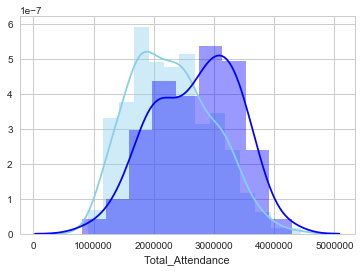

In [11]:
sns.distplot(baseball_pred_data.Total_Attendance.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.Total_Attendance.loc[y == 1], color="blue")

More people show up to successful team's game, but the size of the stadium is factored into this. For example, if two teams are equally successful, the team with the larger stadium should have a greater total attendance. What about per capital income of the metropolitan area that the team is located?

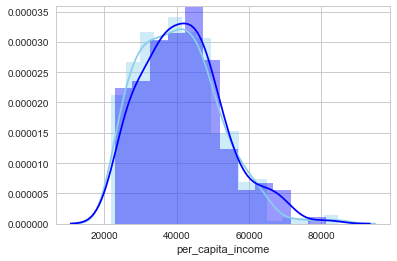

In [12]:
sns.distplot(baseball_pred_data.per_capita_income.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.per_capita_income.loc[y == 1], color="blue")

This I find extremely interesting. I would think that teams in wealthier areas pay more for tickets and the teams are richer as a result. Can't richer teams afford to buy better players? Now, how about runs scored?

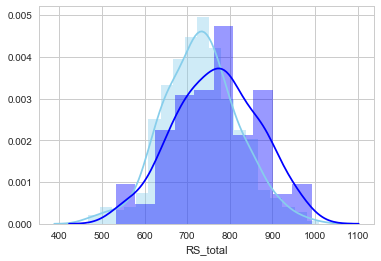

In [13]:
sns.distplot(baseball_pred_data.RS_total.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.RS_total.loc[y == 1], color="blue")

This overall makes sense, as teams with more runs scored and better "offense" will win more games and have a greater chance of entering the playoffs. What about stadium age?

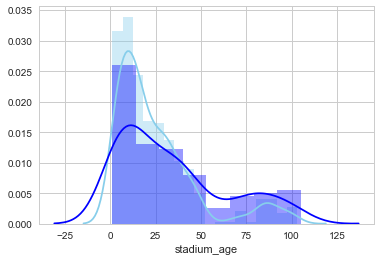

In [14]:
sns.distplot(baseball_pred_data.stadium_age.loc[y == 0] , color="skyblue")
sns.distplot(baseball_pred_data.stadium_age.loc[y == 1], color="blue")

It doesn't look like there's a huge difference here. Perhaps one thing to notice is that playoffs teams have a more uniform distribution when it comes to stadium age. Lastly, does making the playoffs the current year affect their chances next year?

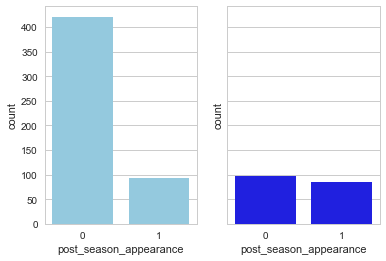

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.countplot(baseball_pred_data.post_season_appearance.loc[y == 0], ax = ax1, color="skyblue")
sns.countplot(baseball_pred_data.post_season_appearance.loc[y == 1], ax = ax2, color="blue")

This is also surprising. I would think that more teams that made the playoffs the previous year would make it the following the year, but the numbers are about even. So, even if a team makes the playoffs, they are nowhere near guaranteed to make the playoffs the following year. However, if the team does not make the playoffs the current year, they are much less likely to make the playoffs the following year. Now that we had a chance to look at the data visuals, let's begin constructing our model.

## Model Building

The only categorical variable is post_season_appearance, and the data was already transformed when the data was loaded on to pandas. Specifically, if the team made the playoffs that year, then they receive a one. If the team failed to make the playoffs, then they get a zero. Using the "Recursive Feature Elimination" algorithm, I can rank my predictor variables in terms of importance. To be honest, I am not completely sure on what basis the algorithm ranks the predictors on. I used a similar algorithm in R, where the basis on choosing variables was on the $R^{2}$ value.

In [16]:
logreg = LogisticRegression()
rfe = RFE(logreg, 1)
rfe = rfe.fit(X, y)
print(rfe.ranking_)

[6 1 5 4 3 7 8 2]


To be honest, this doesn't tell me much. I can choose the top 3 or 4 or 5 or whatever, but what is that magic number? I found that often three variables creates the highest number of correct classifications (http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html), but let's use statistics to investigate this further.

In [53]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.502253
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit                No. Iterations:    6.0000  
Dependent Variable:   postseason_nextyear  Pseudo R-squared:  0.127   
Date:                 2018-09-19 20:38     AIC:               717.1457
No. Observations:     698                  BIC:               753.5314
Df Model:             7                    Log-Likelihood:    -350.57 
Df Residuals:         690                  LL-Null:           -401.58 
Converged:            1.0000               Scale:             1.0000  
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
real_revenue_2016       0.0000   0.0000  0.7386 0.4602 -0.0000  0.0000
W                      -0.0268   0.0142 -1.8938 0.0583 -0.0546  0.0009
Total_Attendance        0.0000   0.0000  1.0109 0.3121 -0.0000  0.0000
per_capita_income      -0.0000   0.0000 -0.0126 0.9899 -0.0000  0.0000
RS_total                0.0074   0.0022  3.4508 0.0006  0.0032  0.0117
stadium_age             0.0074   0.0036  2.0476 0.0406  0.0003  0.0145
post_season_appearance  0.4854   0.2629  1.8463 0.0648 -0.0299  1.0007
RA_total               -0.0080   0.0015 -5.4469 0.0000 -0.0108 -0.0051
======================================================================

"""

There are some interesting p values here that I would not have guessed. For per capita income, I guessed that it would not affect future playoff probability since the distributions on the histograms above were too similar. However, for revenue, I did not expect the p value to be that big. You'd think that with more revenue, a team is able to buy more players, and as a result, create better chances to make the playoffs. One logical explanation could be that high revenue may be due to fan loyalty, but they team performance may still be poor year after year. I mainly think of the Chicago Cubs (except recently).

Anyway, let's keep the variables where the p-value is below $0.1$ for now and create our logistic regression model. This means that the probability that our data is simply a lucky deviation from the real mean (in our model, it's zero) is low, and as a result, we can reject the null hypothesis that the coefficients for the variables is zero. 

In [17]:
new_vars = ['W', 'RS_total', 'stadium_age', 'post_season_appearance', 'RA_total']
X1 = baseball_data[new_vars]
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3, random_state = 0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


Honestly, this is better than I thought. Out of the four predictions, three were correct. However, the amount of data that we have is small. We only have baseball data going back to the early 90's. The score that we got could literally be from noise. It should be beneficial to cross validate our model.

In [19]:
kfold = model_selection.KFold(n_splits=5, random_state=0)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring='accuracy')
print("5-fold cross validation average accuracy: %.3f" % (results.mean()))

5-fold cross validation average accuracy: 0.754


Since the train test split and the cross validation score are similar, we can assume that our model generalizes pretty well. Let's take a look at a confusion matrix.

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[152   9]
 [ 41   8]]


Out of the 210 predictions, 160 was correct while 50 was incorrect. 152 no playoff teams were correctly predicted, while 8 playoff teams were predicted correctly. Now, let's take a look at the classification report. 

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      0.94      0.86       161
          1       0.47      0.16      0.24        49

avg / total       0.71      0.76      0.71       210



From the classification report, we know that out of all teams that are predicted to make the playoffs the following year, 71 percent actually made the playoffs. Also, we know that the of the teams that make the playoffs the following year, 76 percent of them are predicted correctly. I'm not entirely sure that my interpretation of the precision and recall score are entirely correct, but from some research  online, that's what I've come across. Below, we have the ROC curve.

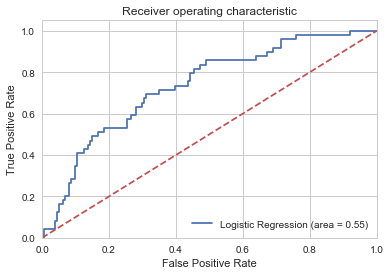

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

For the entire curve, although jagged at places, the true positive rate is greater than the false positive rate. Since the dotted lines means that the classifier is purely random, we want our curve to be as far above the curve as possible. For the most part, I think we did very well.

Now, let's try other classification models and see how they compare with logistic regression.

In [22]:
def run_model(model, alg_name, plot_index):
    # build the model on training data
    model.fit(X_train, y_train)

    # make predictions for test data
    y_pred = model.predict(X_test)
    # calculate the accuracy score
    accuracy =  accuracy_score(y_test, y_pred) * 100
    return accuracy

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
print(run_model(model, "Random Forest", 10))

from xgboost import XGBClassifier

model = XGBClassifier()
print(run_model(model, "XGBoost", 3))

# ------ SVM Classifier ----------------
from sklearn.svm import SVC
model = SVC()
print(run_model(model, "SVM Classifier", 4))

# -------- Nearest Neighbors ----------
from sklearn import neighbors
model = neighbors.KNeighborsClassifier()
print(run_model(model, "Nearest Neighbors Classifier", 5))

# ---------- SGD Classifier -----------------
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(SGDClassifier())
print(run_model(model, "SGD Classifier", 6))

# --------- Gaussian Naive Bayes ---------
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
print(run_model(model, "Gaussian Naive Bayes", 7))

# ----------- Neural network - Multi-layer Perceptron  ------------
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
print(run_model(model, " MLP Neural network ", 8))

75.71428571428571
72.38095238095238
76.66666666666667
74.28571428571429
75.71428571428571
75.71428571428571
75.23809523809524


/Users/HuanLiang/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/HuanLiang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


To be honest, there is not one classification model that immediately outranks the rest. The two models that do as well as the logistic regression are the random forest and nearest neighbors.

This is where I have chosen to halt the project for the time being. There are many more areas I could explore, such as grouping different variables into bins, such as a certain range of wins as one bin and another range as another bin, etc. Also, I could explore other variables, transform them to make the most sense in predicting probability of playoff appearance. All in all, I hope you enjoyed reading about my model and how I came to create this. Let me know if you have any suggestions in improving the model! 